In [9]:
#import the imp liberaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(np.__version__)
print(pd.__version__)

1.26.4
2.2.3


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
tf.random.set_seed(455)
np.random.seed(455)

In [3]:
dataset  = pd.read_csv("./archive/Mastercard_stock_history.csv",index_col="Date",parse_dates=["Date"]).drop(["Dividends","Stock Splits"],axis=1)

print(dataset.head())

                               Open      High       Low     Close     Volume
Date                                                                        
2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985  395343000
2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336  103044000
2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   49898000
2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   30002000
2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   62344000


In [4]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  4733.000000  4733.000000  4733.000000  4733.000000  4.733000e+03
mean    157.218445   158.751430   155.650434   157.248719  1.062101e+07
std     151.827873   153.182400   150.433224   151.846666  1.632991e+07
min       3.677800     4.024589     3.668674     4.006337  6.411000e+05
25%      24.703870    25.007020    24.386382    24.721483  3.020000e+06
50%      87.602214    88.402167    86.976627    87.724739  4.742400e+06
75%     298.458871   302.054722   294.400031   298.368073  1.062100e+07
max     577.330017   582.229980   570.000000   576.309998  3.953430e+08


In [5]:
#check missing values 
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

mastercard stock prices have been on the rise since 2016 . it had a dip in the first quater of 2020 but it gained a stable position  in the latter half of the year . our test dataset consists of one year from 2021 to 2022 , and the rest of the dataset is used for training 

In [15]:
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert(None)


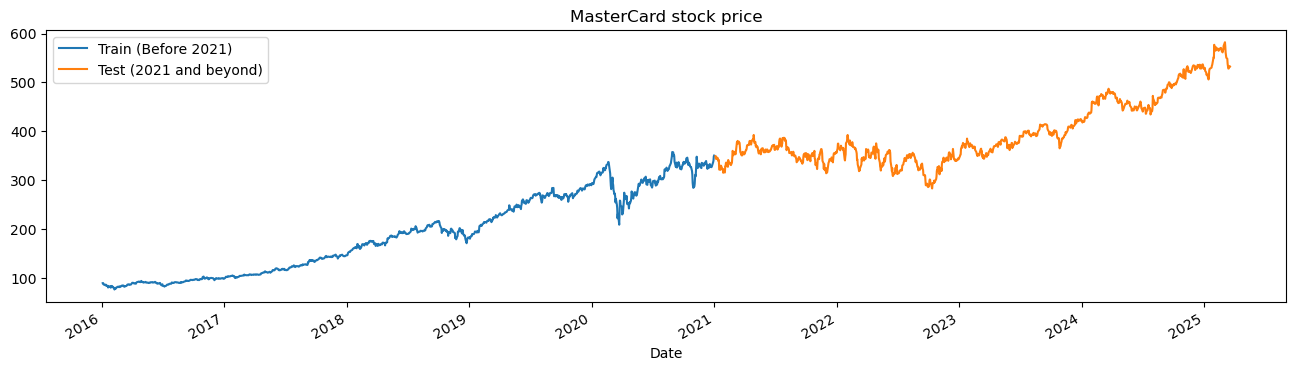

In [16]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)


Data Preprocessing

In [17]:
tstart = 2016
tend = 2020
def train_test_split(dataset,tstart,tend):
    train = dataset.loc[f"{tstart}":f"{tend}","High"].values
    test = dataset.loc[f"{tend+1}":,"High"].values
    return train, test
training_set , test_set = train_test_split(dataset,tstart,tend)

use `MinMaxScaler` function to standardize our training set , which will help us avoid the outlier or anomalies , we can also use standardScaler or any other scaler to normalize our data 

In [32]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)

Split the data into x_train and y_train 

In [20]:
def split_sequence(sequence,n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        end_ix = i+n_steps
        if end_ix >len(sequence)-1:
            break
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

n_steps = 60
features =1
X_train,y_train = split_sequence(training_set_scaled,n_steps)

In [21]:
#Reshape the X_train  for model 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

### LSTM Model

model consists of a single  hidden layer of LSTM and an output layer 

In [27]:

# the LSTM Architecture 
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units=125,activation="tanh",input_shape=(n_steps,features)))
model_lstm.add(tf.keras.layers.Dense(units=1))

# compiling the model 
model_lstm.compile(optimizer="RMSprop",loss="mse")

model_lstm.summary()
Model:"sequantial"

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model_lstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0219
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.0919e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.0847e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.4096e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.8860e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.2547e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.6171e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.9759e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.9735e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.5916e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━

we are going to repeat the preprocessing and normalize the test set
transform then split the dataset into samples ,reshape it, predict and inverse transform the predication into standard form 

In [34]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total)-len(test_set)-n_steps :].values
inputs=inputs.reshape(-1,1)

# scaling 
inputs=sc.transform(inputs)

# split into samples

X_test,y_test = split_sequence(inputs,n_steps)

#reshape

X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],features)

#predication

predication_stock_price= model_lstm.predict(X_test)

#inverse transform the values

predication_stock_price = sc.inverse_transform(predication_stock_price)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [35]:
def plot_predications(test,predicated):
    plt.plot(test,color="gray",label="Real")
    plt.plot(predicated,color = "red",label="Predicted")
    plt.title("Mastercard Stock Price Predication")
    plt.xlabel("Time")
    plt.ylabel("Mastercard Stock Price")
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse= np.sqrt(mean_squared_error(test,predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

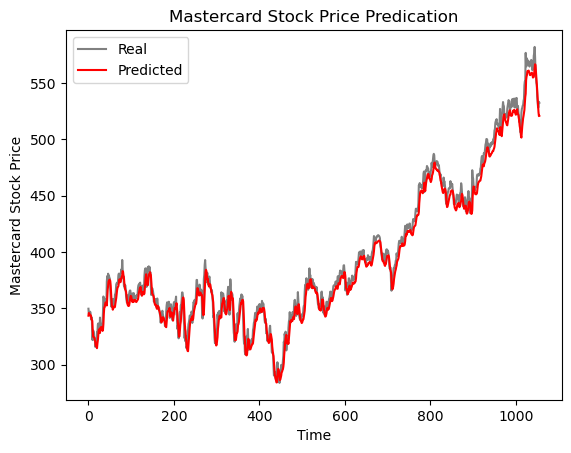

In [36]:
plot_predications(test_set,predication_stock_price)

In [37]:
return_rmse(test_set,predication_stock_price)

The root mean squared error is 8.26.


### GRU model

replace the LSTM layer with GRU . The model structure contains a single GRU layer with 125 units and an output layer 

In [40]:
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(units=125,activation="tanh",input_shape=(n_steps,features)))
model_gru.add(tf.keras.layers.Dense(units=1))

#Compiling the RNN
model_gru.compile(optimizer = "RMSprop",loss="mse")


model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_gru.fit(X_train,y_train,epochs=50,batch_size=32)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0289
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.5502e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8959e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.8889e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.5962e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.6967e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.0373e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.0127e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.6728e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.3538e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.0132e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.6745e-04
Epoch 15/50
38/38 ━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


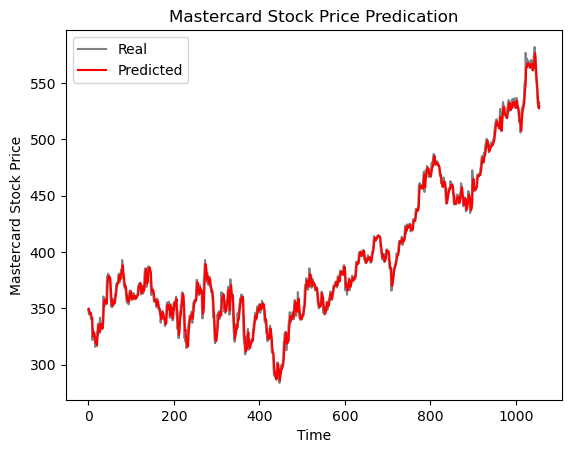

In [43]:
GRU_preidcated_stock_price = model_gru.predict(X_test)
GRU_preidcated_stock_price=sc.inverse_transform(GRU_preidcated_stock_price)
plot_predications(test_set,GRU_preidcated_stock_price)